### We need to implement the histogram equalization for the images 

In [71]:
import imageio
import cv2
import numpy as np
from matplotlib import pyplot as plt

def HSI_to_rgb(img):
    h = img[:,:, 0] # expected range [0, 2pi] we actually should get from 0 to 1 as well
    s = img[:,:, 1] # expected range [0, 1]
    i = img[:,:, 2] # expected range [0, 1]

    h1 = h < 1/3 * 2 * np.pi
    h2 = (1/3 * 2 * np.pi <= h) & (h < 2/3 * 2 * np.pi)
    h3 = 2/3 * 2 * np.pi <= h     

    r = np.zeros_like(h)
    g = np.zeros_like(h)
    b = np.zeros_like(h)
    h_curr = np.zeros_like(h)

    # case 1
    h_curr[h1] = h[h1]
    b[h1] = i[h1] * (1 - s[h1])
    r[h1] = i[h1] * (1 + (s[h1] * np.cos(h_curr[h1])) / (np.cos(np.pi/3 - h_curr[h1])))
    g[h1] = 3 * i[h1] - (r[h1] + b[h1])

    # case 2    
    h_curr[h2] = h[h2] - (2/3 * np.pi)
    r[h2] = i[h2] * (1 - s[h2])
    g[h2] = i[h2] * (1 + (s[h2] * np.cos(h_curr[h2])) / (np.cos(np.pi/3 - h_curr[h2])))
    b[h2] = 3 * i[h2] - (r[h2] + g[h2])

    # case 3
    h_curr[h3] = h[h3] - (4/3 * np.pi)
    g[h3] = i[h3] * (1 - s[h3])
    b[h3] = i[h3] * (1 + (s[h3] * np.cos(h_curr[h3])) / (np.cos(np.pi/3 - h_curr[h3])))
    r[h3] = 3 * i[h3] - (g[h3] + b[h3])    

    r = r / max(r.flatten())
    g = g / max(g.flatten())
    b = b / max(b.flatten())
    
    return np.stack((r,g,b),axis=2)

def rgb_to_HSI(img):

    with np.errstate(divide="ignore", invalid="ignore"):

        # load image with 32 floating point type
        rgb = np.float32(img)/255.0

        # Separating RGB    
        r = rgb[:,:,0]
        g = rgb[:,:,1]
        b = rgb[:,:,2]        

        # Intensity
        intensity = (r+b+g)/3

        # Saturation
        min = np.minimum(np.minimum(r,g),b)
        sat = 1 - ((3/(r+g+b+0.0000001))*min)

        # Hue
        hue = np.arccos((0.5*((r-g)+(r-b)))/((np.sqrt((r-g)**2+(r-b)*(g-b)))))
        hue[b>g] = 2*np.pi - hue[b>g]        

        return np.stack((hue,sat,intensity),axis=2)     


def normalize_hsi(img_hsi):
    img_hsi_copy = img_hsi.copy()
    img_hsi_norm = np.zeros(shape=(img_hsi_copy.shape), dtype=np.uint8)
    img_hsi_norm[:,:,0] = np.uint8((img_hsi_copy[:,:,0] / (2 * np.pi)) * 255)
    img_hsi_norm[:,:,1] = np.uint8(img_hsi_copy[:,:,1] * 255)
    img_hsi_norm[:,:,2] = np.uint8(img_hsi_copy[:,:,2] * 255)

    return img_hsi_norm

def normalize_rgb(img_rgb):
    img_rgb_copy = img_rgb.copy()
    return np.uint8(img_rgb_copy * 255)

def read_img(img_path):
    return imageio.v3.imread(img_path)



In [72]:
img_path = "../../../images/used_images/light_dark/"
img_name = "DSC_0015.jpg"

img_rgb = read_img(img_path+img_name)
print("Image Shape: ", img_rgb.shape)

# Converting RGB to HSI
img_hsi = rgb_to_HSI(img_rgb)

img_hsi_norm = normalize_hsi(img_hsi)

# Converting back to RGB
img_back_rgb = HSI_to_rgb(img_hsi)
img_back_rgb_norm = normalize_rgb(img_back_rgb)

Image Shape:  (4000, 6000, 3)


C:\Users\sebastian\AppData\Local\Temp\ipykernel_8660\261055450.py:73: RuntimeWarning: invalid value encountered in cast
  img_hsi_norm[:,:,0] = np.uint8((img_hsi_copy[:,:,0] / (2 * np.pi)) * 255)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
c:\Users\sebastian\miniconda3\envs\cv701\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


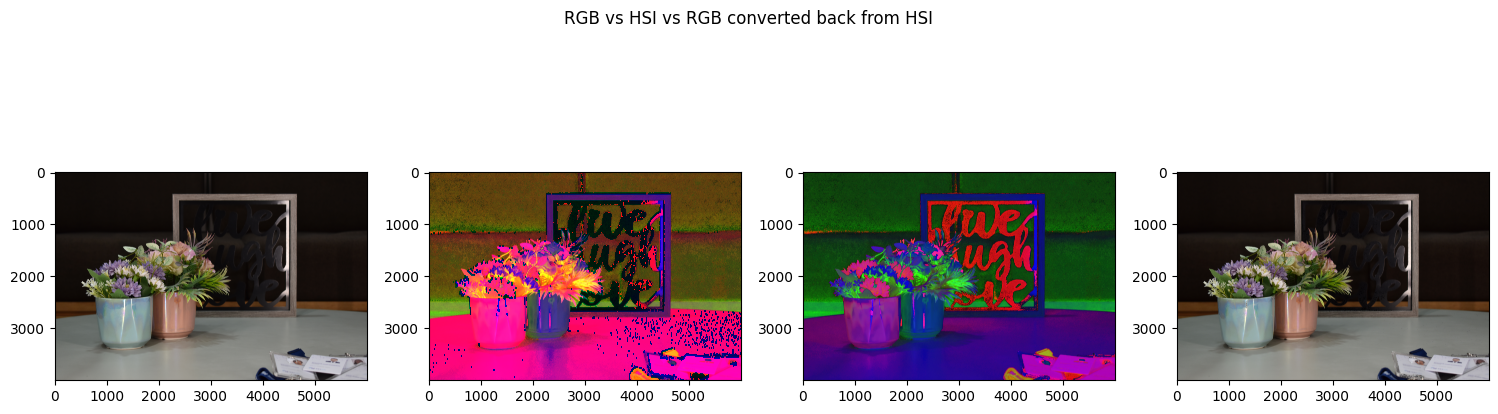

In [73]:
fig, axs = plt.subplots(1, 4)

axs[0].imshow(img_rgb)
axs[1].imshow(img_hsi)
axs[2].imshow(img_hsi_norm)
axs[3].imshow(img_back_rgb_norm)
fig.suptitle('RGB vs HSI vs RGB converted back from HSI')
fig.set_size_inches(18.5, 5.5)
plt.show()

In [74]:
def create_histogram_hsi(img_hsi):

    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Intensity Histogram in HSI color space and corresponding image')
    fig.set_size_inches(18.5, 5.5)
    
    hist,_ = np.histogram(img_hsi[:,:,2].flatten(),256,[0,1])
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()    

    axs[0].hist((img_hsi[:,:,2]*255).ravel(),256,[0,256])
    axs[0].plot(cdf_normalized, color = 'r')
    axs[0].legend(('cdf','histogram'), loc = 'upper left')        
    axs[1].imshow(normalize_hsi(img_hsi))
    plt.plot()
    plt.show()

def create_histogram_rgb(img=None):        
    fig, axs = plt.subplots(1, 4)
    fig.suptitle('RGB Histogram and corresponding image')
    fig.set_size_inches(18.5, 5.5)

    color = ('red','green','blue')        

    cdfs = np.empty(shape=(3,256))    
    hists = []
    tot_max_cdf = 0

    for i,col in enumerate(color):
        hist,_ = np.histogram(img[:,:,i].flatten(),256,[0,256])
        cdf = hist.cumsum()
        hists.append(hist)        
        cdfs[i] = cdf               
        if(cdf.max() > tot_max_cdf):
            tot_max_cdf = cdf.max()    

    for i,col in enumerate(color):        
        cdf_normalized = cdfs[i] * float(hists[i].max()) / np.max(cdfs.flatten())                     
        axs[i].plot(cdf_normalized, color = 'orange')
        axs[i].hist(img[:,:,i].ravel(),256,[0,256], color = col)        

    axs[0].legend(('cdf','histogram'), loc = 'upper left')  
    axs[1].legend(('cdf','histogram'), loc = 'upper left')  
    axs[2].legend(('cdf','histogram'), loc = 'upper left')  
    axs[3].imshow(img)

    plt.plot()
    plt.show()

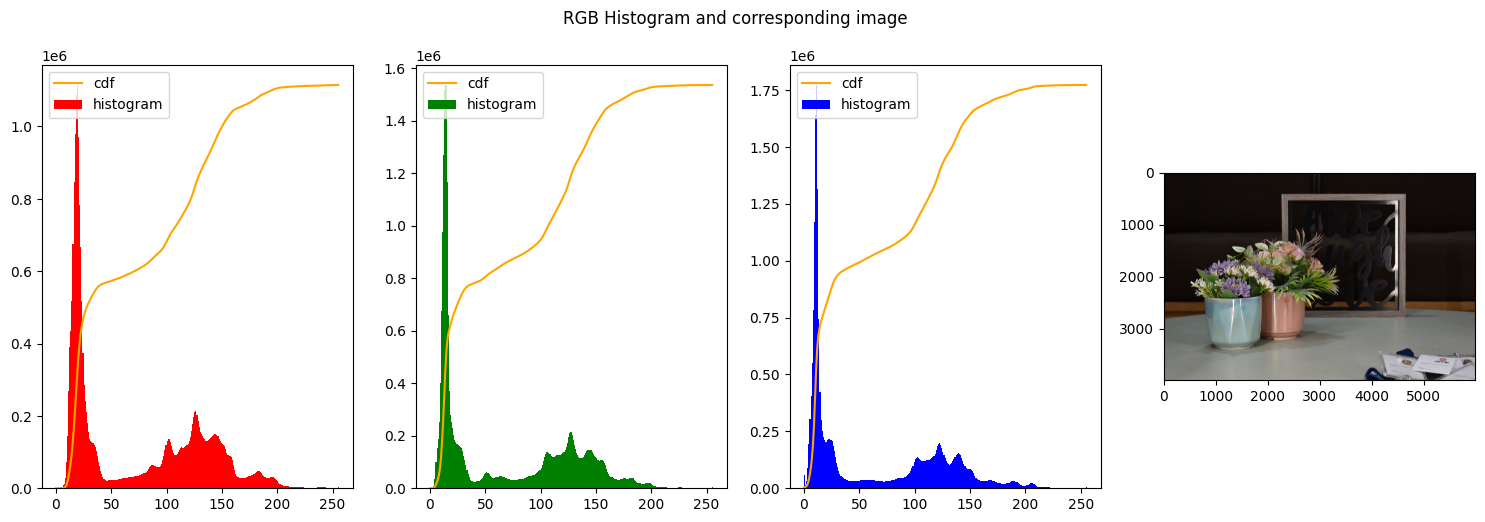

In [75]:
# Creating the histogram for every channel
create_histogram_rgb(img_rgb)

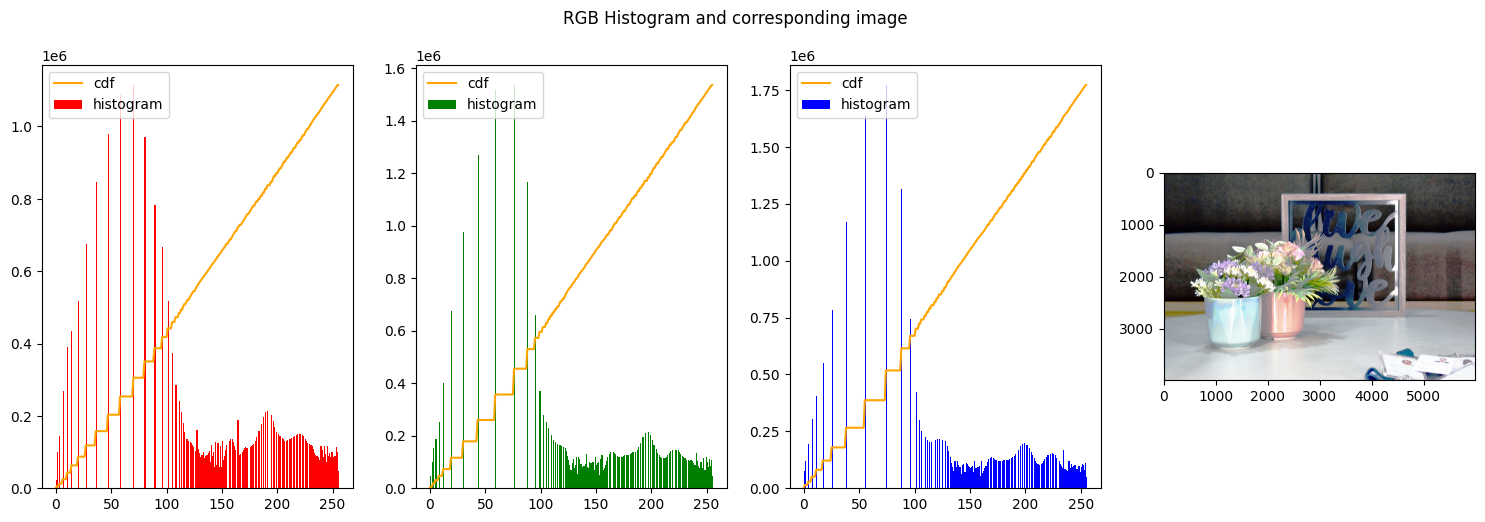

In [76]:
def equalize_rgb_channels():
    img_rgb_equalized = img_rgb.copy()
    r_equal = np.uint8(img_rgb_equalized[:,:,0])
    g_equal = np.uint8(img_rgb_equalized[:,:,1])
    b_equal = np.uint8(img_rgb_equalized[:,:,2])

    r_equal = cv2.equalizeHist(r_equal)
    g_equal = cv2.equalizeHist(g_equal)
    b_equal = cv2.equalizeHist(b_equal)

    res_rgb_equal = np.stack((r_equal,g_equal,b_equal),axis=2)

    create_histogram_rgb(res_rgb_equal)

    return res_rgb_equal

res_rgb_equal = equalize_rgb_channels()

### Equalization on HSI

The idea of equalization is to make the above histogram similar to a uniform distribution

C:\Users\sebastian\AppData\Local\Temp\ipykernel_8660\261055450.py:73: RuntimeWarning: invalid value encountered in cast
  img_hsi_norm[:,:,0] = np.uint8((img_hsi_copy[:,:,0] / (2 * np.pi)) * 255)


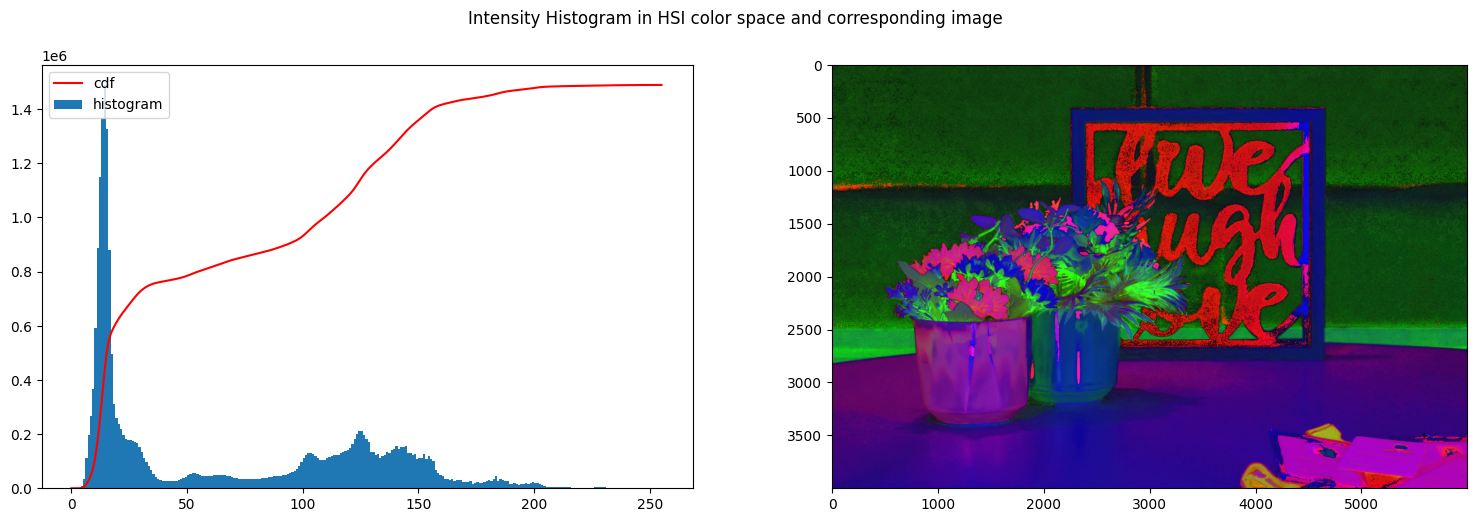

In [77]:
# Creating the histogram for intensity channel
create_histogram_hsi(img_hsi)

255
255
6.2585454


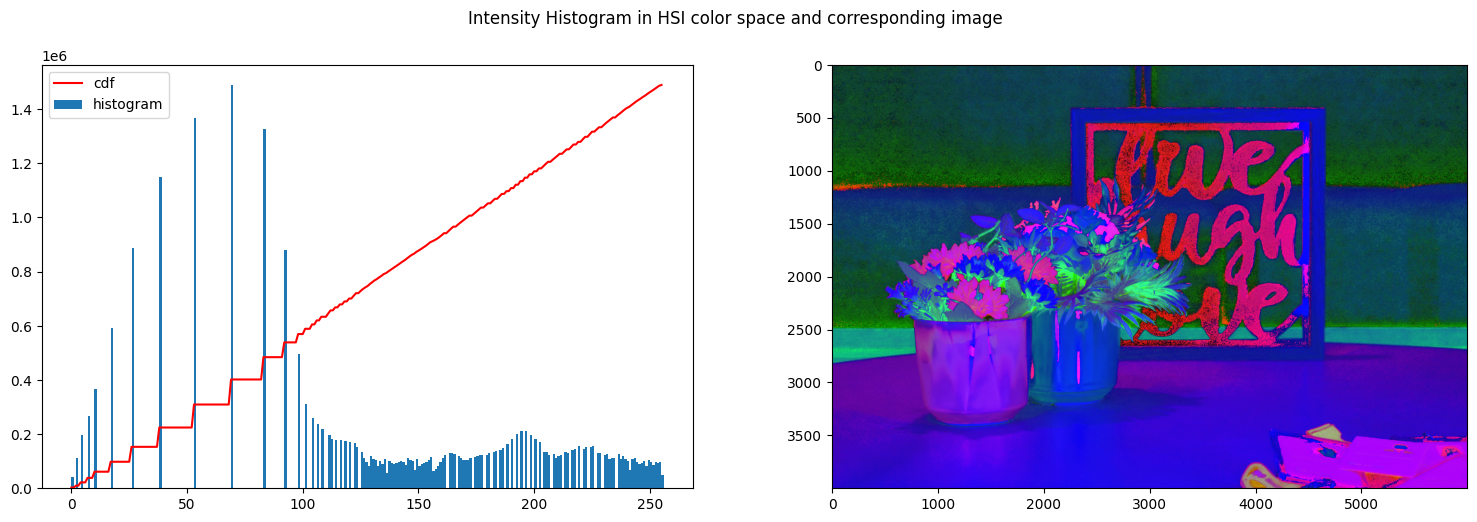

In [78]:
img_hsi_equalized = img_hsi_norm.copy()
src_8 = np.uint8(img_hsi_equalized[:,:,2])

print(max(src_8.flatten()))

dst = cv2.equalizeHist(src_8)

print(max(dst.flatten()))

img_hsi_equalized_float = np.zeros(shape=(img_hsi_equalized.shape), dtype=np.float32)

img_hsi_equalized_float[:,:,0] = np.float32((img_hsi_equalized[:,:,0]/255.0) * 2 * np.pi)
img_hsi_equalized_float[:,:,1] = np.float32(img_hsi_equalized[:,:,1]/255.0)
img_hsi_equalized_float[:,:,2] = np.float32(dst/255.0)

print(max(img_hsi_equalized_float[:,:,0].flatten()))

create_histogram_hsi(img_hsi_equalized_float)

1.0


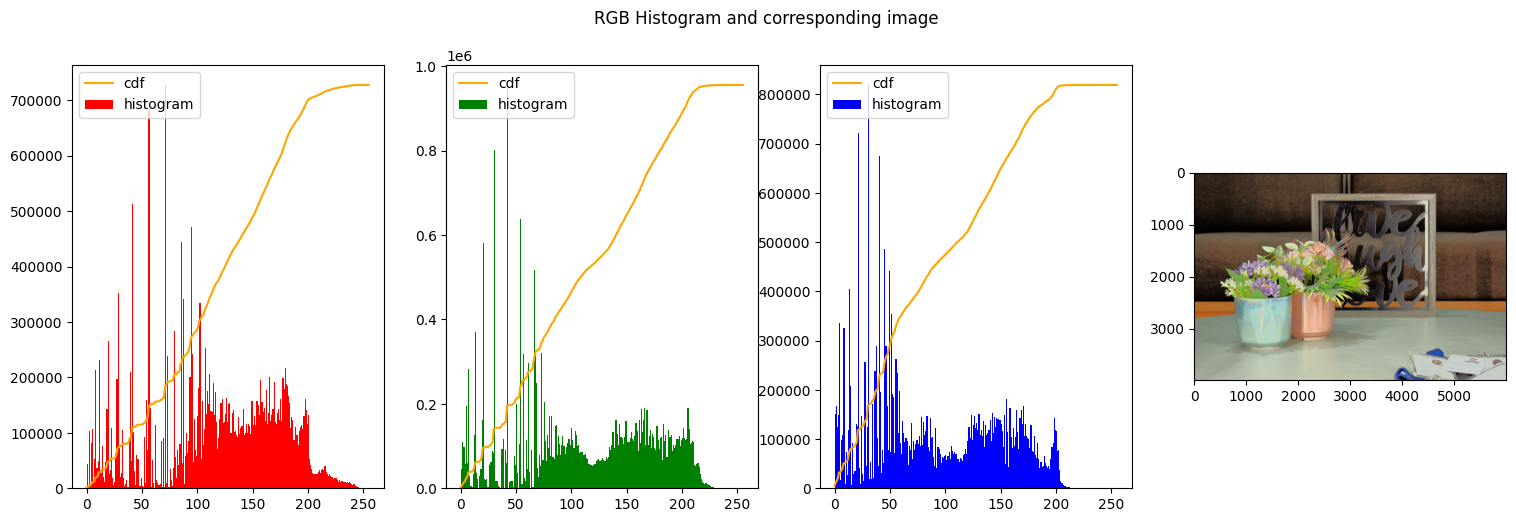

In [79]:
new_img = HSI_to_rgb(img_hsi_equalized_float)

print(max(new_img.flatten()))

new_img_8 = np.uint8(new_img * 255) # clip the values to 0 to 255
create_histogram_rgb(new_img_8)

In [80]:
def compare(img1, img2, titles):
    res = np.hstack((img1,img2)) #stacking images side-by-side
    plt.figure(figsize=(20,10))
    plt.title('{} vs {}'.format(titles[0],titles[1]))
    plt.imshow(res,cmap='gray')

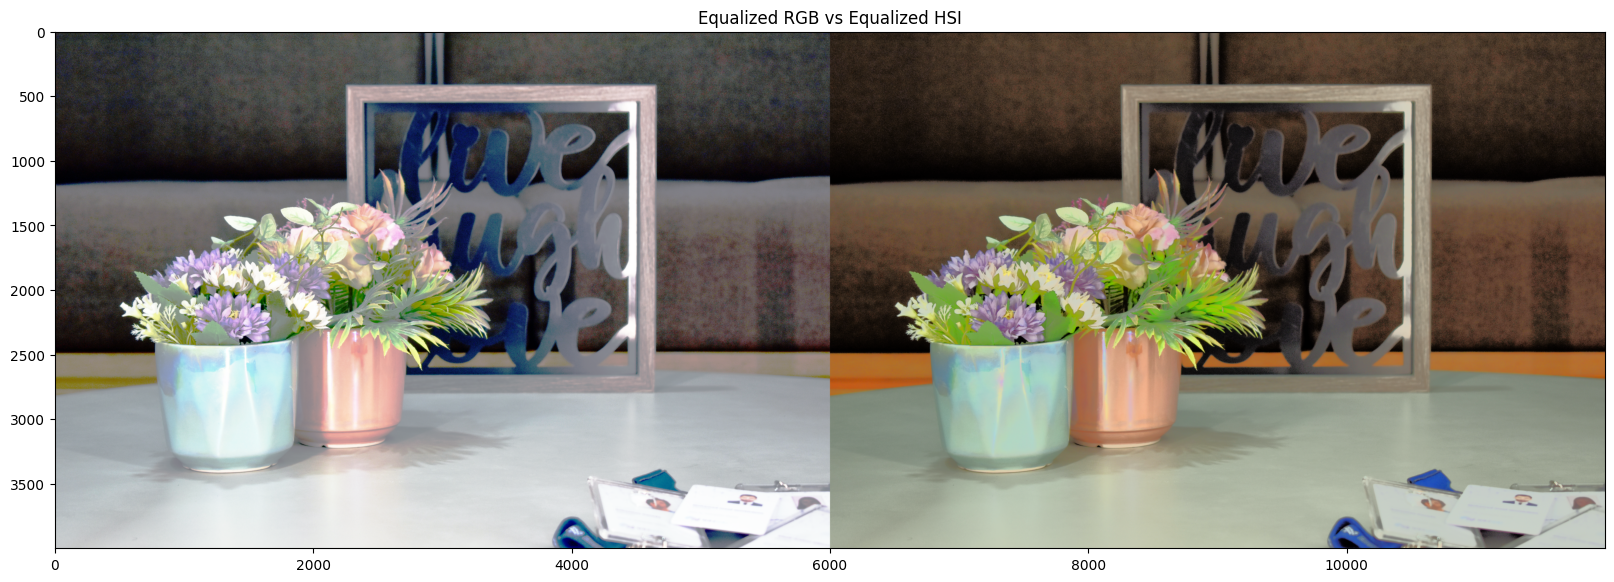

In [81]:
compare(res_rgb_equal, new_img_8, ["Equalized RGB", "Equalized HSI"])

## Contrast Stretching - alpha & beta

1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


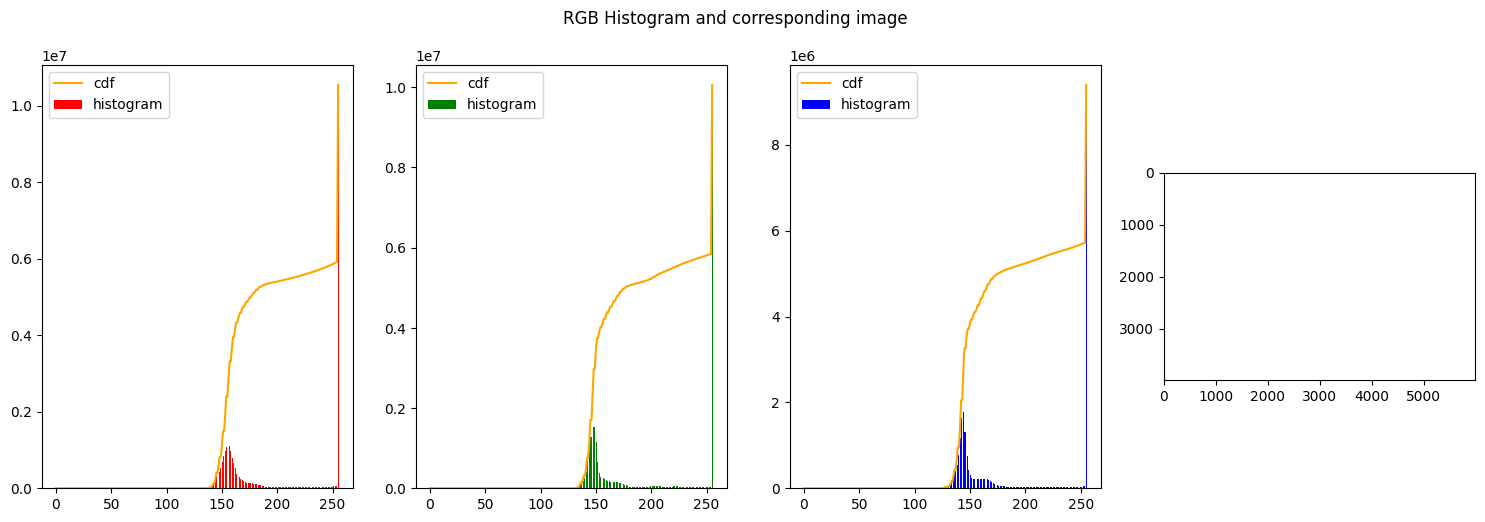

In [82]:
img_rgb_ab = img_rgb.copy()/255

alpha = 1.5
beta = 0.5
new_img_a = np.clip(alpha*img_rgb_ab + beta, 0, 1)

print(np.max(new_img_a.flatten()))

img_rgb_ab = img_rgb.copy()/255

alpha = 0.5
beta = 0.05
new_img_b = np.clip(alpha*img_rgb_ab + beta, 0, 1)

create_histogram_rgb((new_img_a/np.max(new_img_a.flatten())) * 255)


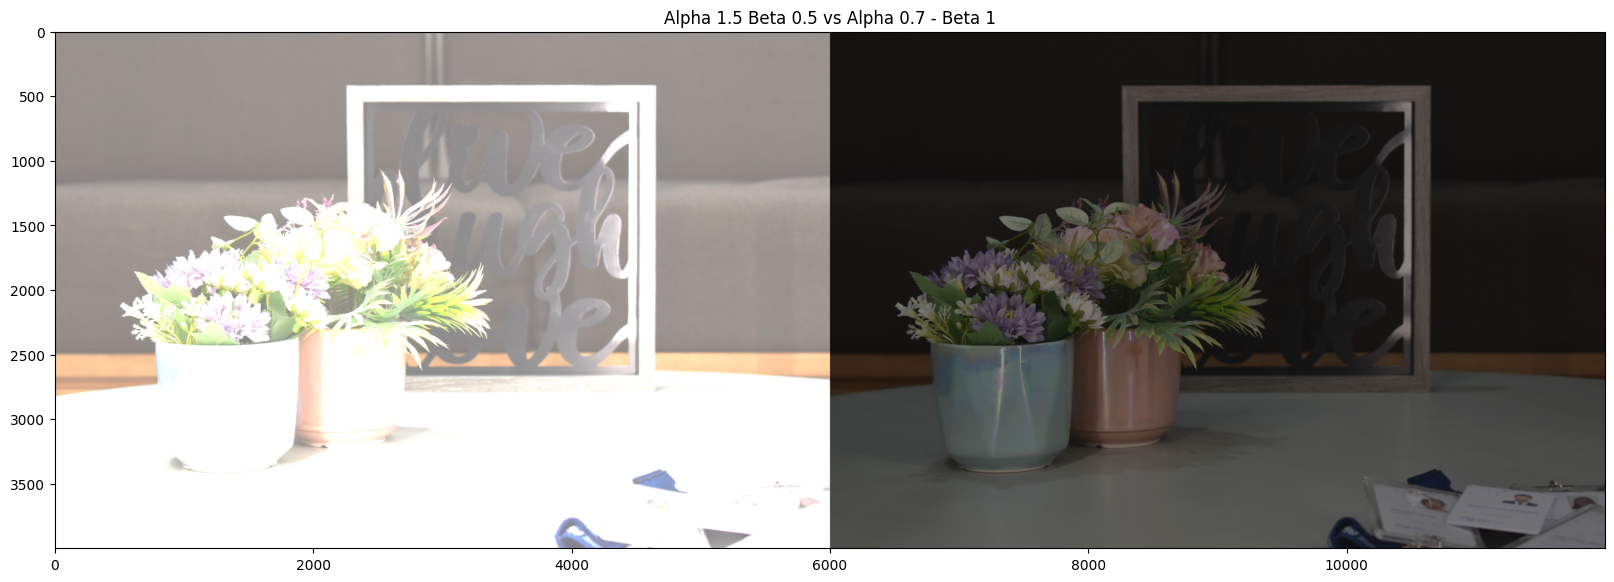

In [83]:
compare(new_img_a, new_img_b, ["Alpha 1.5 Beta 0.5", "Alpha 0.7 - Beta 1"])